In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import sys
import pickle
import blip_analysis as ba
import exp_blip_models as em
from scipy.cluster.hierarchy import dendrogram, linkage
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe
from scipy.stats import ttest_ind
import importlib
importlib.reload(em)
importlib.reload(ba)

b
b


<module 'blip_analysis' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/blip_analysis.py'>

In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()

Found odour 1
Found odour 3
Found odour 5


In [3]:
full_models1 = pickle.Unpickler(open('221209_full_models1.pkl', 'rb')).load()
full_models2 = pickle.Unpickler(open('221209_full_models2.pkl', 'rb')).load()
full_models3 = pickle.Unpickler(open('221209_full_models3.pkl', 'rb')).load()

cao_models1 = pickle.Unpickler(open('221209_cao_models1.pkl', 'rb')).load()
cao_models2 = pickle.Unpickler(open('221209_cao_models2.pkl', 'rb')).load()
cao_models3 = pickle.Unpickler(open('221209_cao_models3.pkl', 'rb')).load()

conc_models1 = pickle.Unpickler(open('221209_conc_models1.pkl', 'rb')).load()
conc_models2 = pickle.Unpickler(open('221209_conc_models2.pkl', 'rb')).load()
conc_models3 = pickle.Unpickler(open('221209_conc_models3.pkl', 'rb')).load()

onset_models1 = pickle.Unpickler(open('221209_onset_models1.pkl', 'rb')).load()
onset_models2 = pickle.Unpickler(open('221209_onset_models2.pkl', 'rb')).load()
onset_models3 = pickle.Unpickler(open('221209_onset_models3.pkl', 'rb')).load()

In [4]:
def plot_pred_odour(fig, gs, true_vals, pred_vals, chosen_indexes, legend_ax_index=2):

    subgs = gs.subgridspec(ncols=len(chosen_indexes), nrows=1)
    axs = []
    for ax_i, index in enumerate(chosen_indexes):
        if ax_i != 0:
            
            ax = fig.add_subplot(subgs[ax_i], sharey=axs[-1])
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax = fig.add_subplot(subgs[ax_i])
        ax.scatter(range(32), true_vals[index], label='True')
        ax.scatter(range(32), pred_vals[index], label='Prediction')
        axs.append(ax)
        ax.set_xticks(range(32))
        ax.set_xticklabels(glyphs, fontsize=8, rotation=90)
        if ax_i == legend_ax_index:
            ax.legend()
    
    return axs

def pred_other_odour(model1, model2, model3, unit_usrt, ui, pred_trial = -1, ratio_schema = 'pred_trial', fitting_schema=None):
    full_array = em.trial_arrays['diff_array']
    if ratio_schema == 'pred_trial':
        ratio_w1 = model1.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
        ratio_w2 = model2.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
    elif ratio_schema == 'mean':
        ratio_w1 = np.mean(model1.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
        ratio_w2 = np.mean(model2.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
    elif ratio_schema == 'max':
        if model1.true_resp[-1] > model2.true_resp[-1]:
            ratio_w1 = 1
            ratio_w2 = 0
        else:
            ratio_w1 = 0
            ratio_w2 = 1
    elif ratio_schema == 'pred_trial_diff':
        model1_diff = abs(model1.true_resp[-1] - model1.true_resp[0])
        model2_diff = abs(model2.true_resp[-1] - model2.true_resp[0])
        ratio_w1 = model1_diff/(model1_diff+model2_diff)
        ratio_w2 = model2_diff/(model1_diff+model1_diff)
    if fitting_schema == 'exclude_t':
        pred_ws = model1.opt_out.x[:-1]*ratio_w1 + model2.opt_out.x[:-1]*ratio_w2
        avg_thresh = (model1.opt_out.x[-1] + model2.opt_out.x[-1])/2
        pred_out = pred_ws @ full_array[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]) - avg_thresh)/pred_out
        pred_ws = scale*pred_ws
        pred_ws = list(pred_ws) + [avg_thresh]
    if fitting_schema == 'negative':
        full_array_1 = np.append(full_array, np.ones((32, 1)), axis=1)
        pred_ws = model1.opt_out.x*ratio_w1 - model2.opt_out.x*ratio_w2
        pred_out = pred_ws @ full_array_1[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]))/pred_out
        pred_ws = scale*pred_ws
    else:
        pred_ws = model1.opt_out.x*ratio_w1 + model2.opt_out.x*ratio_w2
        full_array_1 = np.append(full_array, np.ones((32, 1)), axis=1)
        pred_out = pred_ws @ full_array_1[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]))/pred_out
        pred_ws = scale*pred_ws
        

    
    model_test = em.ExponentialCustomTrialArray(unit_usrt, ui, full_array)
    model_test.fit(W=pred_ws)
    return model_test

def pred_other_odour_split(model1, model2, model3, unit_usrt, ui, pred_trial = -1, ratio_schema = 'pred_trial', exclude_t=True, negative_ratio=False):
    full_array = em.trial_arrays['diff_array']
    model_test = em.ExponentialCustomTrialArray(unit_usrt, ui, full_array)
    training_opts = []
    all_pred_test_avg = []
    for repeat in range(model1.X_train_avg.shape[0]):
        if ratio_schema == 'pred_trial':

            ratio_w1 = model1.X_train_avg[repeat][-1]/((model1.X_train_avg[repeat][-1]+model2.X_train_avg[repeat][-1]))
            ratio_w2 = model2.X_train_avg[repeat][-1]/((model1.X_train_avg[repeat][-1]+model2.X_train_avg[repeat][-1]))
        elif ratio_schema == 'mean':
            ratio_w1 = np.mean(model1.X_train_avg[repeat])/((np.mean(model1.X_train_avg[repeat])+np.mean(model2.X_train_avg[repeat])))
            ratio_w2 = np.mean(model2.X_train_avg[repeat])/((np.mean(model1.X_train_avg[repeat])+np.mean(model2.X_train_avg[repeat])))
        elif ratio_schema == 'max':
            if model1.X_train_avg[repeat][-1] > model2.X_train_avg[repeat][-1]:
                ratio_w1 = 1
                ratio_w2 = 0
            else:
                ratio_w1 = 0
                ratio_w2 = 1
        elif ratio_schema == 'pred_trial_diff':
            model1_diff = abs(model1.X_train_avg[repeat][-1] - model1.X_train_avg[repeat][0])
            model2_diff = abs(model2.X_train_avg[repeat][-1] - model2.X_train_avg[repeat][0])
            ratio_w1 = model1_diff/(model1_diff+model2_diff)
            ratio_w2 = model2_diff/(model1_diff+model1_diff)
        else:
            print('unknown ratio_schema', ratio_schema)
        if negative_ratio:
            ratio_w2 = -ratio_w2
        if exclude_t:
            pred_ws = model1.training_opts[repeat].x[:-1]*ratio_w1 + model2.training_opts[repeat].x[:-1]*ratio_w2
            avg_thresh = (model1.training_opts[repeat].x[-1] + model2.training_opts[repeat].x[-1])/2
            pred_out = pred_ws @ full_array[pred_trial]
            scale = (np.log(model3.X_train_avg[repeat][pred_trial]) - avg_thresh)/pred_out
            pred_ws = scale*pred_ws
            pred_ws = list(pred_ws) + [avg_thresh]
        else:
            pred_ws = model1.training_opts[repeat].x*ratio_w1 + model2.training_opts[repeat].x*ratio_w2
            full_array_1 = np.append(full_array, np.ones((32, 1)), axis=1)
            pred_out = pred_ws @ full_array_1[pred_trial]
            scale = (np.log(model3.X_train_avg[repeat][pred_trial]))/pred_out
            pred_ws = scale*pred_ws           
        
        model_test.fit(model3.X_train_avg[repeat], W=pred_ws)
        training_opts.append(pred_ws)
        all_pred_test_avg.append(model_test.fit_score)
    model_test.training_opts = np.array(training_opts)
    model_test.pred_test_avg = np.array(all_pred_test_avg)
    return model_test



In [22]:
ui = full_responding_units[0]
model1 = full_models1[ui]
model2 = full_models2[ui]
model3 = full_models3[ui]
model_test = pred_other_odour_split(model1, model2, model3, unit_usrt3, ui)

In [23]:
model_test.pred_test_avg

array([0.66374513, 0.40701342, 0.34373729, 0.34298957, 0.36041975,
       0.34815113, 0.43020248, 0.36638313, 0.39325644, 0.32562326,
       0.51270483, 0.33488375, 0.33911016, 0.33893974, 0.4061295 ,
       0.35558666, 0.34355981, 0.53143188, 0.37649661, 0.43808732,
       0.38153045, 0.35239849, 0.80860902, 0.33900239, 0.86854606,
       0.37215004, 0.34020649, 0.46048792, 0.36498697, 0.43240541,
       0.47354479, 0.56320674, 0.55179796, 0.46275596, 0.37539622,
       0.64909403, 0.33468284, 0.68912162, 0.44086412, 0.43206505,
       0.37308883, 0.33778805, 0.50626635, 0.52386807, 0.59259039,
       0.34874415, 0.3844603 , 0.34247736, 0.46789668, 0.50860474,
       0.37958512, 0.39889952, 0.54172877, 0.60440081, 0.3894555 ,
       0.34593821, 0.37500828, 0.32922042, 0.43437809, 0.4029825 ,
       0.33847754, 0.4401475 , 0.32907614, 0.34695415, 0.32737775,
       0.50388319, 0.3778836 , 0.39181382, 0.34334217, 0.46432538,
       0.45742596, 0.45214366, 0.35153951, 0.44797159, 0.39810

In [5]:
## pred odour further work
full_responding_units = []
for i in good_indexes:
    model1 = full_models1[i]
    model2 = full_models2[i]
    model3 = full_models3[i]
    
    odour1_resp_diff = abs(model1.true_resp[0] - model1.true_resp[-1])
    odour2_resp_diff = abs(model2.true_resp[0] - model2.true_resp[-1])
    odour3_resp_diff = abs(model3.true_resp[0] - model3.true_resp[-1])
    
    odour1_var = np.sqrt(model1.unit_sr_var[0])
    odour2_var = np.sqrt(model2.unit_sr_var[0])
    odour3_var = np.sqrt(model3.unit_sr_var[0])
    if i == 41:
        print(odour1_resp_diff, odour1_var)
    if odour1_resp_diff > odour1_var and odour2_resp_diff > odour2_var and odour3_resp_diff > odour3_var:
        full_responding_units.append(i)

16.26666666666667 4.935134806219133


In [6]:
def plot_three_pred_model(ui):
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
    pred_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)
    pred_model2 = pred_other_odour(full_models3[ui], full_models1[ui], full_models2[ui], unit_usrt2, ui)
    pred_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui)
    full_models1[ui].fit()
    full_models2[ui].fit()
    full_models3[ui].fit()

    ax[0].plot(pred_model1.true_resp, '.')
    ax[0].plot(full_models1[ui].pred_resp, '.')
    ax[0].plot(pred_model1.pred_resp, '.')
    ax[0].set_title(f'F error {full_models1[ui].fit_score:0.2f}\nO error {pred_model1.fit_score:0.2f}')

    ax[1].plot(pred_model2.true_resp, '.')
    ax[1].plot(full_models2[ui].pred_resp, '.')
    ax[1].plot(pred_model2.pred_resp, '.')
    ax[1].set_title(f'F error {full_models2[ui].fit_score:0.2f}\nO error {pred_model2.fit_score:0.2f}')


    ax[2].plot(pred_model3.true_resp, '.', label='True response')
    ax[2].plot(full_models3[ui].pred_resp, '.',label='Full predictoion')
    ax[2].plot(pred_model3.pred_resp, '.',label='Odour prediction')
    ax[2].set_title(f'F error {full_models3[ui].fit_score:0.2f}\nO error {pred_model3.fit_score:0.2f}')

    ax[2].legend()


In [232]:
### Fix this for the updated pred_other_odour

scores_pred1 = []
scores_pred2 = []
scores_pred3 = []

scores_full1 = []
scores_full2 = []
scores_full3 = []

scores_abs1 = []
scores_abs2 = []
scores_abs3 = []

scores_neg1 = []
scores_neg2 = []
scores_neg3 = []

scores_split1 = []
scores_split2 = []
scores_split3 = []

pred_tests_split1 = []
pred_tests_split2 = []
pred_tests_split3 = []


for ui in full_responding_units:
    pred_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)
    pred_model2 = pred_other_odour(full_models3[ui], full_models1[ui], full_models2[ui], unit_usrt2, ui)
    pred_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui)
    scores_pred1.append(pred_model1.fit_score)
    scores_pred2.append(pred_model2.fit_score)
    scores_pred3.append(pred_model3.fit_score)
    
    abs_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui, ratio_schema='pred_trial_diff')
    abs_model2 = pred_other_odour(full_models3[ui], full_models1[ui], full_models2[ui], unit_usrt2, ui, ratio_schema='pred_trial_diff')
    abs_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui, ratio_schema='pred_trial_diff')
    scores_abs1.append(abs_model1.fit_score)
    scores_abs2.append(abs_model2.fit_score)
    scores_abs3.append(abs_model3.fit_score)

    neg_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui, ratio_schema='pred_trial_diff', fitting_schema='negative')
    neg_model2 = pred_other_odour(full_models3[ui], full_models1[ui], full_models2[ui], unit_usrt2, ui, ratio_schema='pred_trial_diff', fitting_schema='negative')
    neg_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui, ratio_schema='pred_trial_diff', fitting_schema='negative')
    scores_neg1.append(neg_model1.fit_score)
    scores_neg2.append(neg_model2.fit_score)
    scores_neg3.append(neg_model3.fit_score)
    
    split_model1 = pred_other_odour_split(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)
    split_model2 = pred_other_odour_split(full_models3[ui], full_models1[ui], full_models2[ui], unit_usrt2, ui)
    split_model3 = pred_other_odour_split(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui)
    scores_split1.append(split_model1.fit_score)
    scores_split2.append(split_model2.fit_score)
    scores_split3.append(split_model3.fit_score)
    pred_tests_split1.append(split_model1.pred_test_avg)
    pred_tests_split2.append(split_model2.pred_test_avg)
    pred_tests_split3.append(split_model3.pred_test_avg)


    
    full_models1[ui].fit()
    full_models2[ui].fit()
    full_models3[ui].fit()
    scores_full1.append(full_models1[ui].fit_score)
    scores_full2.append(full_models2[ui].fit_score)
    scores_full3.append(full_models3[ui].fit_score)
    
    

ranked_fits1 = np.argsort(scores_pred1)
ranked_fits2 = np.argsort(scores_pred2)
ranked_fits3 = np.argsort(scores_pred3)
ranked_fits_ui1 = np.array(full_responding_units)[ranked_fits1]
ranked_fits_ui2 = np.array(full_responding_units)[ranked_fits2]
ranked_fits_ui3 = np.array(full_responding_units)[ranked_fits3]

/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py:85: RuntimeWarning: overflow encountered in power
  return np.array([np.power((i-j), 2) for i, j in zip(true_resp, pred_resp)])/vars


132 132


<ErrorbarContainer object of 3 artists>

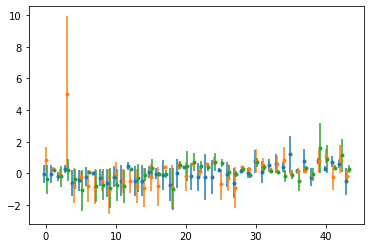

In [50]:
pred_tests_split_all = np.concatenate([pred_tests_split1, pred_tests_split2, pred_tests_split3])
pred_tests_split_mean = np.mean(pred_tests_split_all, axis=1)
pred_tests_split_max = np.max(pred_tests_split_all, axis=1) - pred_tests_split_mean
pred_tests_split_min = pred_tests_split_mean - np.min(pred_tests_split_all, axis=1)
print(len(pred_tests_split_max), len(pred_tests_split_min))
plt.errorbar(np.arange(-0.2, 44-0.2), np.log10(pred_tests_split_mean)[:44], np.log10(pred_tests_split_min, pred_tests_split_max)[:44], fmt='.')
plt.errorbar(np.arange(0, 44), np.log10(pred_tests_split_mean)[44:88], np.log10(pred_tests_split_min, pred_tests_split_max)[44:88], fmt='.')
plt.errorbar(np.arange(0.2, 44.2), np.log10(pred_tests_split_mean)[88:], np.log10(pred_tests_split_min, pred_tests_split_max)[88:], fmt='.')


<ErrorbarContainer object of 3 artists>

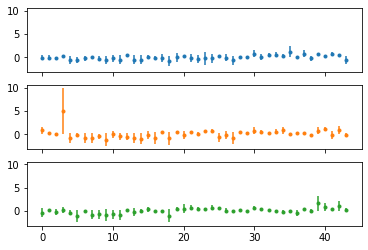

In [52]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
ax[0].errorbar(range(44),  np.log10(pred_tests_split_mean)[:44], np.log10(pred_tests_split_min, pred_tests_split_max)[:44], fmt='.')
ax[1].errorbar(np.arange(0, 44), np.log10(pred_tests_split_mean)[44:88], np.log10(pred_tests_split_min, pred_tests_split_max)[44:88], fmt='.', color='C1')
ax[2].errorbar(np.arange(0, 44), np.log10(pred_tests_split_mean)[88:], np.log10(pred_tests_split_min, pred_tests_split_max)[88:], fmt='.', color='C2')

In [233]:
best_neg_fits1 = np.min([scores_abs1, scores_neg1], axis=0)
best_neg_fits2 = np.min([scores_abs2, scores_neg2], axis=0)
best_neg_fits3 = np.min([scores_abs3, scores_neg3], axis=0)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f3de28ee358>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f3de28ee2b0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f3de28ee5f8>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f3de28ee7f0>}

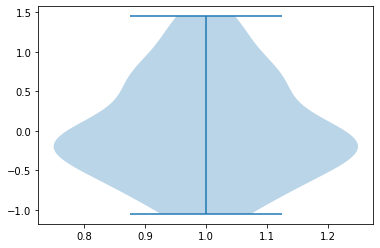

In [235]:
plt.violinplot(np.log10(best_neg_fits1))

In [67]:
print(np.median(scores_pred1), np.median(best_neg_fits1))
print(np.median(scores_pred2), np.median(best_neg_fits2))
print(np.median(scores_pred3), np.median(best_neg_fits3))

0.8761948550133911 0.8497056924066859
0.7700116852231063 1.1759232547882332
1.101479923615948 0.9425900579243479


([<matplotlib.axis.XTick at 0x7fef1c9c8240>,
 <a list of 9 Text xticklabel objects>)

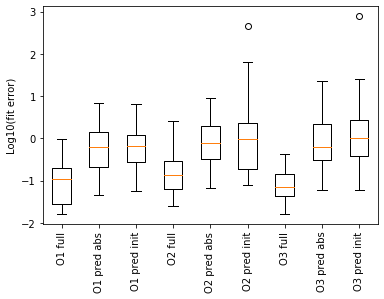

In [12]:
plt.boxplot([np.log10(scores_full1), np.log10(best_neg_fits1), np.log10(scores_pred1), np.log10(scores_full2), np.log10(best_neg_fits2), np.log10(scores_pred2), np.log10(scores_full3), np.log10(best_neg_fits3), np.log10(scores_pred3)]);
plt.ylabel('Log10(fit error)')
plt.xticks(range(1, 10), labels=['O1 full', 'O1 pred abs', 'O1 pred init', 'O2 full', 'O2 pred abs', 'O2 pred init', 'O3 full', 'O3 pred abs', 'O3 pred init'], rotation=90)

In [48]:
ttest_ind(best_neg_fits3, scores_pred3)

Ttest_indResult(statistic=-1.037716662775876, pvalue=0.30231092106172275)

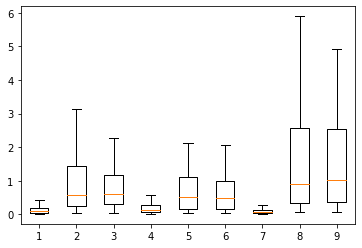

In [24]:

plt.boxplot([scores_full1, scores_abs1, scores_pred1, scores_full2, scores_abs2, scores_pred2, scores_full3, scores_abs3, scores_pred3], showfliers=False);

{'whiskers': [<matplotlib.lines.Line2D at 0x7fef1ddcebe0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fef1ddd8080>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fef1ddce1d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7feefc114358>,
 'fliers': [],
 'means': []}

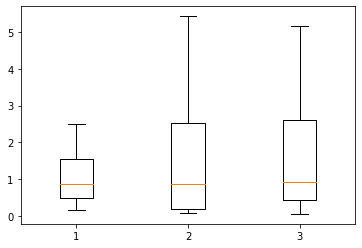

In [74]:
plt.boxplot([scores_split1, scores_split2, scores_split3], showfliers=False)

In [16]:
model.fit_split()

In [8]:
dasked = daskify.Daskified()
dasked.start_cluster()
client = dasked.client

In [9]:
def split_models(ui, file_name):
    full_models = pickle.Unpickler(open(file_name, 'rb')).load()
    model = full_models[ui]
    model.fit_split()
    return model

In [10]:
delays = [dask.delayed(split_models)(i, '221209_full_models1.pkl') for i in range(145)]
outs1 = client.compute(delays)
delays = [dask.delayed(split_models)(i, '221209_full_models2.pkl') for i in range(145)]
outs2 = client.compute(delays)
delays = [dask.delayed(split_models)(i, '221209_full_models3.pkl') for i in range(145)]
outs3 = client.compute(delays)

In [18]:
dasked.current_futures = outs3
dasked.check_progress()

finished 145


In [19]:
full_models1 = [i.result() for i in outs1]
full_models2 = [i.result() for i in outs2]
full_models3 = [i.result() for i in outs3]

In [28]:
full_models1[0]

In [37]:
for ui in full_responding_units:
    pred_model1 = pred_other_odour_split(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 9)

ValueError: X must have 2 or fewer dimensions

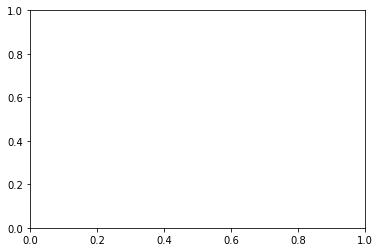

In [74]:
plt.violinplot([pred_tests_split1])

[ 0.92290515  0.92108016  0.64757173  1.92102837  0.25632646  0.36142085
  0.6230128   1.09972604  0.54864937  0.25487856  0.63390628  0.35144632
  2.73913257  0.32643179  0.35316634  1.22229173  0.96765151  0.79237659
  0.1930738   1.0125616   2.36938846  0.63739453  0.58970065  0.6178743
  0.61079227  1.6564978   0.88128953  0.25700218  1.42982936  1.0175738
  5.8702065   1.18315028  3.23753964  4.15025397  2.46423867 16.12046083
  1.50772316  6.05548618  0.61699416  6.1089095   1.94637033  5.49446609
  3.95292734  0.30813939]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f3e715b89b0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f3e715b8780>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f3e71546160>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f3e715463c8>}

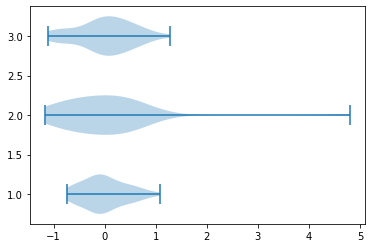

In [80]:
print(np.array(pred_tests_split1).mean(axis=-1))
plt.violinplot([np.log10(pred_tests_split1).mean(axis=-1), np.log10(pred_tests_split2).mean(axis=-1), np.log10(pred_tests_split3).mean(axis=-1)], vert=False)

In [91]:
scores1 = []
scores2 = []
scores3 = []

for i in good_indexes:
    pred_model1 = pred_other_odour_split(full_models3[i], full_models2[i], full_models1[i], unit_usrt1, i, )
    pred_model2 = pred_other_odour_split(full_models1[i], full_models3[i], full_models2[i], unit_usrt2, i, )
    pred_model3 = pred_other_odour_split(full_models1[i], full_models2[i], full_models3[i], unit_usrt3, i, )
    scores1.append(pred_model1.pred_test_avg.mean())
    scores2.append(pred_model2.pred_test_avg.mean())
    scores3.append(pred_model3.pred_test_avg.mean())
scores1 = np.array(scores1)
scores2 = np.array(scores2)
scores3 = np.array(scores3)

/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py:85: RuntimeWarning: overflow encountered in power
  return np.array([np.power((i-j), 2) for i, j in zip(true_resp, pred_resp)])/vars


/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/numpy/core/function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/matplotlib/mlab.py:1542: RuntimeWarning: invalid value encountered in subtract
  diff = self.dataset - points[:, i, np.newaxis]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f3e71ca5eb8>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f3e2aa1a780>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f3e2aa2b048>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f3e2aa2b278>}

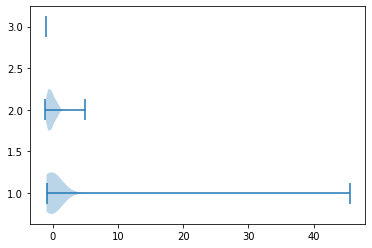

In [89]:
plt.violinplot([np.log10(scores1), np.log10(scores2), np.log10(scores3)], vert=False)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f3e298cb5c0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f3e298cb4a8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f3e298cbac8>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f3e298cbcf8>}

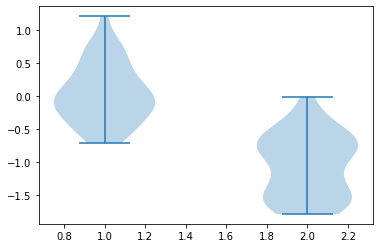

In [103]:
reduced_full_respinding_units = np.array([np.where(good_indexes == i)[0][0] for i in full_responding_units])
plt.violinplot([np.log10(scores1)[reduced_full_respinding_units], np.log10(scores_full1)])

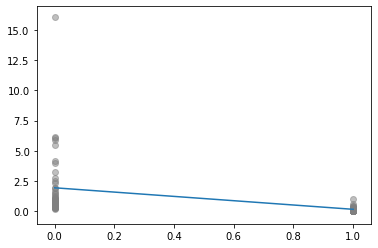

In [112]:
def slope_plot(data):
    mean_data = np.mean(data, axis=1)
    plt.plot(mean_data)
    for j in range(len(data)):
        plt.scatter([j for i in range(len(data[j]))], data[j], alpha=0.5, color='grey')

data = []
slope_plot(np.array([scores1[reduced_full_respinding_units], scores_full1]))

In [168]:
all_scores1 = []
all_scores2 = []
all_scores3 = []
for ratio_schema in ['pred_trial', 'pred_trial_diff']:
    for exclude_t in [True, False]:
        for negative_ratio in [True, False]:
            for ui in good_indexes:

                pred_model1 = pred_other_odour_split(full_models2[ui], full_models3[ui], full_models1[ui], unit_usrt1, ui, ratio_schema=ratio_schema, exclude_t=exclude_t, negative_ratio=negative_ratio)
                pred_model2 = pred_other_odour_split(full_models1[ui], full_models3[ui], full_models2[ui], unit_usrt2, ui, ratio_schema=ratio_schema, exclude_t=exclude_t, negative_ratio=negative_ratio)
                pred_model3 = pred_other_odour_split(full_models2[ui], full_models1[ui], full_models3[ui], unit_usrt3, ui, ratio_schema=ratio_schema, exclude_t=exclude_t, negative_ratio=negative_ratio)
                pred_model_score1 = pred_model1.pred_test_avg
                pred_model_score1 = np.mean(pred_model_score1[np.isfinite(pred_model_score1)])
                pred_model_score2 = pred_model2.pred_test_avg
                pred_model_score2 = np.mean(pred_model_score2[np.isfinite(pred_model_score2)])
                pred_model_score3 = pred_model3.pred_test_avg
                pred_model_score3 = np.mean(pred_model_score3[np.isfinite(pred_model_score3)])
                all_scores1.append(pred_model_score1)
                all_scores2.append(pred_model_score2)
                all_scores3.append(pred_model_score3)
all_scores1 = np.array(all_scores1)
all_scores2 = np.array(all_scores2)
all_scores3 = np.array(all_scores3)

/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py:85: RuntimeWarning: overflow encountered in power
  return np.array([np.power((i-j), 2) for i, j in zip(true_resp, pred_resp)])/vars
/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py:104: RuntimeWarning: overflow encountered in exp
  pred_firing = np.exp(inter_exp)
/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py:69: RuntimeWarning: divide by zero encountered in log
  return np.sum(pred_response-true_response*np.log(pred_response))
/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py:69: RuntimeWarning: invalid value encountered in subtract
  return np.sum(pred_response-true_response*np.log(pred_response))
/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in double_scalars
/camp/home/warnert/.conda/envs/blip_manu/l

In [169]:
all_scores1 = all_scores1.reshape(2, 2, 2, 130)
all_scores2 = all_scores2.reshape(2, 2, 2, 130)
all_scores3 = all_scores3.reshape(2, 2, 2, 130)

In [163]:
print(pred_model1.unit_sr_var)

[74.82666667 48.42666667 58.59555556 57.90666667 70.84888889 89.76
 56.18222222 55.98222222 60.78222222 62.31555556 42.76       49.90666667
 31.84       32.99555556 37.84888889 49.44       66.77333333 85.78222222
 31.98222222 54.79555556 49.72888889 56.44888889 70.93333333 48.88888889
 55.98222222 53.26222222 48.64       49.22666667 44.04       55.39555556
 52.02222222 58.29333333]


In [187]:
mean_all_scores1 = np.nanmean(all_scores1.min(axis=-1), axis=-1)
mean_all_scores2 = np.nanmean(all_scores2.min(axis=-1), axis=-1)
mean_all_scores3 = np.nanmean(all_scores3.min(axis=-1), axis=-1)

mean_responding_scores1 = np.nanmean(all_scores1[:, :, :, reduced_full_respinding_units].min(axis=-1), axis=-1)
mean_responding_scores2 = np.nanmean(all_scores2[:, :, :, reduced_full_respinding_units].min(axis=-1), axis=-1)
mean_responding_scores3 = np.nanmean(all_scores3[:, :, :, reduced_full_respinding_units].min(axis=-1), axis=-1)

neged_all_scores1 = all_scores1.min(axis=2)
neged_all_scores2 = all_scores2.min(axis=2)
neged_all_scores3 = all_scores3.min(axis=2)

neged_resp_scores1 = all_scores1[:, :, :, reduced_full_respinding_units].min(axis=2)
neged_resp_scores2 = all_scores2[:, :, :, reduced_full_respinding_units].min(axis=2)
neged_resp_scores3 = all_scores3[:, :, :, reduced_full_respinding_units].min(axis=2)

In [224]:
print(np.median(neged_all_scores1.reshape(4, -1)[0]), np.median(neged_resp_scores1.reshape(4, 44)[0]))

0.5117975945372205 0.6282106206284613


In [205]:
def quartile_plot(xs, data):
    mean_data = np.median(data, axis=1)
    lower_quartile = [np.quantile(i, 0.25) for i in data]
    upper_quartile = [np.quantile(i, .75) for i in data]
    lower_quartile = mean_data - lower_quartile
    upper_quartile = upper_quartile - mean_data
    print(len(data), len(lower_quartile))
    
    plt.errorbar(xs, mean_data, yerr=(lower_quartile, upper_quartile), fmt='o')

4 4
4 4
4 4


Text(0, 0.5, 'Log10(fit score)')

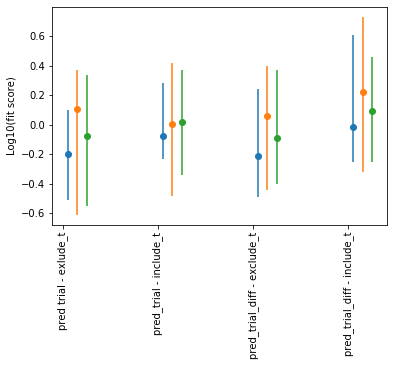

In [231]:
# quartile_plot(np.arange(-0.25, 4-0.25), np.log10(neged_all_scores1.reshape(4, 130)))
# quartile_plot(np.arange(-0.15, 4-0.15), np.log10(neged_all_scores2.reshape(4, 130)))
# quartile_plot(np.arange(-0.05, 4-0.05), np.log10(neged_all_scores3.reshape(4, 130)))
quartile_plot(np.arange(0.05, 4.05), np.log10(neged_resp_scores1.reshape(4, 44)))
quartile_plot(np.arange(0.15, 4.15), np.log10(neged_resp_scores2.reshape(4, 44)))
quartile_plot(np.arange(0.25, 4.25), np.log10(neged_resp_scores3.reshape(4, 44)))
plt.xticks(range(4), labels=['pred trial - exlude_t', 'pred_trial - include_t', 'pred_trial_diff - exclude_t', 'pred_trial_diff - include_t'], rotation=90)
plt.ylabel('Log10(fit score)')

In [228]:
for i in range(3):
    for j in range(i+1, 4):
        print(ttest_ind(np.log10(neged_resp_scores1.reshape(4, 44)[i]), np.log10(neged_resp_scores1.reshape(4, 44)[j])))
        print(ttest_ind(np.log10(neged_resp_scores2.reshape(4, 44)[i]), np.log10(neged_resp_scores2.reshape(4, 44)[j])))
        print(ttest_ind(np.log10(neged_resp_scores3.reshape(4, 44)[i]), np.log10(neged_resp_scores3.reshape(4, 44)[j])))

Ttest_indResult(statistic=-0.7629525516682358, pvalue=0.44757946226450407)
Ttest_indResult(statistic=0.8814740869423701, pvalue=0.3805182489135053)
Ttest_indResult(statistic=0.6417171796076406, pvalue=0.5227635845175054)
Ttest_indResult(statistic=-0.9582599569784038, pvalue=0.34061793073818314)
Ttest_indResult(statistic=-0.8396190222392819, pvalue=0.4034500543792833)
Ttest_indResult(statistic=-0.6813690044571236, pvalue=0.4974687609041366)
Ttest_indResult(statistic=-1.7702086505262888, pvalue=0.08023631685752525)
Ttest_indResult(statistic=0.09546882132690364, pvalue=0.9241645597803467)
Ttest_indResult(statistic=-0.7653639002058177, pvalue=0.44615025183424295)
Ttest_indResult(statistic=-0.8786154559269578, pvalue=0.38205805384081815)
Ttest_indResult(statistic=-0.9849808369430355, pvalue=0.32739653847860795)
Ttest_indResult(statistic=-0.9322312739472806, pvalue=0.3538268285033003)
Ttest_indResult(statistic=-1.489553884526369, pvalue=0.13999992329975328)
Ttest_indResult(statistic=-1.80609

Text(0, 0.5, 'Log10(Fit score)')

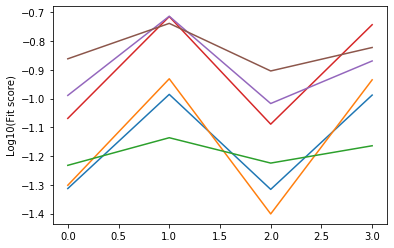

In [188]:
plt.plot(np.log10(mean_all_scores1.flatten()))
plt.plot(np.log10(mean_all_scores2.flatten()))
plt.plot(np.log10(mean_all_scores3.flatten()))

plt.plot(np.log10(mean_responding_scores1.flatten()))
plt.plot(np.log10(mean_responding_scores2.flatten()))
plt.plot(np.log10(mean_responding_scores3.flatten()))

plt.ylabel('Log10(Fit score)')


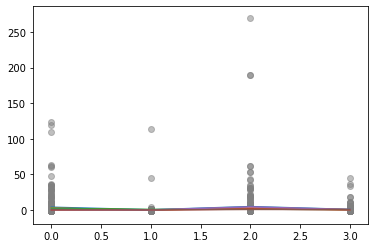

In [192]:
def slope_plot(data):
    mean_data = np.mean(data, axis=1)
    plt.plot(mean_data)
    for j in range(len(data)):
        plt.scatter([j for i in range(len(data[j]))], data[j], alpha=0.5, color='grey')

slope_plot(np.log10(neged_all_scores1.reshape(4, 130)))
slope_plot(np.log10(neged_all_scores2.reshape(4, 130)))
slope_plot(np.log10(neged_all_scores3.reshape(4, 130)))
slope_plot(np.log10(neged_resp_scores1.reshape(4, 44)))
slope_plot(np.log10(neged_resp_scores2.reshape(4, 44)))
slope_plot(np.log10(neged_resp_scores3.reshape(4, 44)))

In [147]:
print(np.where(all_scores1 == np.max(all_scores1)))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 17,  48,  50,  58,  59,  80, 107, 111, 123, 126, 128,  30,  49,
        39,  45,  48,  49,  52,  58,  71,  86, 107, 119, 124,  33, 104,
       110, 111, 123,  30,  44,  45,   1,  36,  37,  40,  47,  48,  72,
        76,  81,  91, 111]))


In [149]:
test_model = pred_other_odour_split(full_models2[ui], full_models3[ui], full_models1[ui], unit_usrt1, good_indexes[17], ratio_schema='pred_trial', exclude_t=True, negative_ratio=True)

In [151]:
np.mean(test_model.pred_test_avg)

0.8839889501614597